## Compressed sensing with QFT

**Compressed sensing objective**

Given a high dimensional signal $\mathbf{x} \in\mathbb{R}^{D}$ we want to find a vector $\mathbf{s}^*$ in the set. 

$$
\argmin_{\mathbf{s} \in \mathbb{R}^{D}}  \|\mathbf{s}\|_1  \\
\text{s.t. } C\mathbf{x} = CF^{-1}\mathbf{s}
$$


**Tensorized extension of compressed sensing**

Given a high dimensional signal $\mathbf{x} \in\mathbb{R}^{D\times\cdots\times D}$ represented in TT format with ranks $\{R_i\}_{i=1}^N$ we want to find a TT-vector $\mathbf{s}^*$ in the set. 

$$
\argmin_{\mathbf{s} \in \mathbb{R}^{D}}  \|\mathbf{s}\|_1  \\
\text{s.t. } \mathcal{C}\mathcal{x} = \mathcal{C}\mathcal{F}^{-1}\mathcal{s}
$$

where $\mathcal{C}\,\&\,\mathcal{F}$ are Matrix Product Operators (MPO).


### Constrained optimization

#### Misc

In [ ]:
# Install packages
!pip install quimb 

In [ ]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
from scipy.optimize import minimize
from math import sqrt

# =======================================================
# (Example 1) Standard Constrained Optimization in NumPy
# =======================================================

# def f(x):
#     print(x)
#     return sqrt(0.1*x[0]*x[1])

# def ineq_constraint(x):
#     return x[0] - x[1]

# con = {'type': 'ineq', 'fun': ineq_constraint}

# x0 = [1, 1]
# res = minimize(f, x0, method='SLSQP', constraints=con, bounds=[(0, None) for i in range(len(x0))], options={'disp': True, 'iprint': 2})


# ===============================================
# (Example 2) Simple MPS constrained optimization
# ===============================================

# def f(x, H, R, D, verbose=False):
#     # x represents a D^H tensor via a TT-vector. Shape: (H*R^2*D)
#     x = x.reshape(H, R, R, D)

#     # Each MPS core is of shape (Rl, Rr, D)
#     arrays = [x[0][0:1, ...]] + [x[i] for i in range(1, H-1)] + [x[H-1][..., 0:1, :]]
#     if verbose:
#         print('\n'.join(str(a.shape) for a in arrays))

#     # Create the MPS
#     mps = qtn.MatrixProductState(arrays)
#     return mps.norm()


# H, R, D = 8, 2, 2
# con = [{'type': 'ineq', 'fun': lambda x, idx=i: (x[idx] - 0.5)} for i in range(H*R*R*D)]

# x0 = np.random.rand(H*R*R*D)
# res = minimize(f, x0, method='SLSQP', constraints=con, args=(H, R, D), options={'disp': True, 'iprint': 2})


# ================================================
# (Main) MPS compressed sensing (Example 3)
# ================================================

def obj_fn(x, L, R, D, verbose=False):
    # x represents a D^H tensor via a TT-vector. Shape: (H*R^2*D)
    x = x.reshape(L, R, R, D)
    x_mps = vec2mps(x, L, R, D)
    return x_mps.norm()  # should make l1 norm

def vec2mps(x, L, R, D) -> qtn.MatrixProductState:
     x = x.reshape(L, R, R, D)
     return qtn.MatrixProductState([x[0][0:1, ...]] + [x[i] for i in range(1, L-1)] + [x[L-1][..., 0:1, :]])

def vec2mpo(x, L, R, D) -> qtn.MatrixProductOperator:
     x = x.reshape(L, R, R, D, D)
     return qtn.MatrixProductOperator([x[0][0:1, ...]] + [x[i] for i in range(1, L-1)] + [x[L-1][..., 0:1, :, :]])


L, R, D = 8, 2, 4

# Create MPO transforms
c = np.random.rand(L, R, R, D, D)  # sampler MPO
finv = np.random.rand(L, R, R, D, D)  # inverse fourier MPO
c_mpo = qtn.MatrixProductOperator([c[0][0:1, ...]] + [c[i] for i in range(1, L-1)] + [c[L-1][..., 0:1, :, :]])
finv_mpo = qtn.MatrixProductOperator([finv[0][0:1, ...]] + [finv[i] for i in range(1, L-1)] + [finv[L-1][..., 0:1, :, :]])
w_mpo = c_mpo.apply(finv_mpo)  # combined MPO


# Original signal
x_targ_mps = qtn.MPS_rand_state(L=L, bond_dim=R, phys_dim=D)  # dense tensor
y_mps = c_mpo.apply(x_targ_mps)

con = []
# i.e. y - CFs = 0
con.append({'type': 'eq', 'fun': lambda s_t: (w_mpo.apply(vec2mps(s_t, L, R, D)) - y_mps).norm()})

x0 = np.random.rand(L*R*R*D)
res = minimize(obj_fn, x0, method='SLSQP', constraints=con, args=(L, R, D), options={'disp': True, 'iprint': 2})

  NIT    FC           OBJFUN            GNORM
    1   130     5.750997E+10     2.693384E+02
    2   261     2.657291E+05     2.150438E+02
    3   392     6.523824E+03     2.093686E+02
    4   522     6.971943E+03     1.970488E+02
    5   652     4.275163E+09     1.804037E+02
    6   783     3.435327E+06     1.846679E+02
    7   913     3.178742E+07     2.132773E+02
    8  1045     5.473043E+10     2.121769E+02
    9  1177     5.049110E+13     2.702926E+02
   10  1309     1.991316E+16     3.112463E+02
   11  1442     4.339439E+09     3.637591E+02
   12  1573     7.850922E+10     4.811807E+02
   13  1705     9.212569E+07     4.802707E+02
   14  1836     6.248081E+09     2.660805E+02
   15  1967     4.597640E+11     2.641672E+02
   16  2099     1.227795E+06     2.463116E+02
   17  2230     2.198992E+08     1.738935E+02
   18  2361     2.419083E+10     1.240734E+02
   19  2493     7.663578E+10     1.413877E+02
   20  2625     7.405568E+05     1.144086E+02
   21  2757     1.371338E+07     9

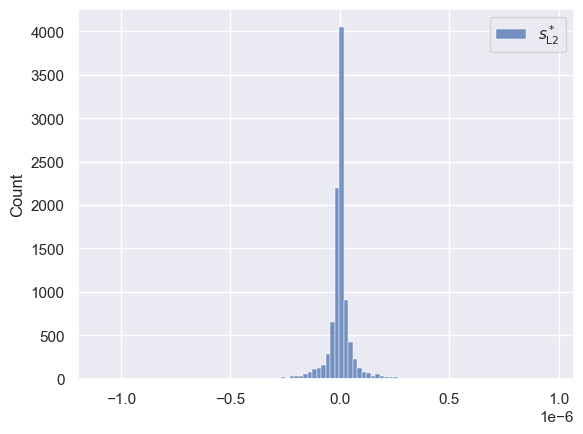

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


def random_samples_with_amplitudes(mps, num_samples=5):
    L = mps.L
    d = mps.phys_dim()
    results = []

    for _ in range(num_samples):
        # uniformly random configuration
        cfg = np.random.randint(0, d, size=L)
        mapping = {mps.site_ind(i): int(cfg[i]) for i in range(L)}

        # contract to get amplitude
        amp = mps.isel(mapping).contract(output_inds=())

        results.append(amp)

    return results


samples_l2 = random_samples_with_amplitudes(vec2mps(res.x, L, R, D), num_samples=10000)
samples_random = random_samples_with_amplitudes(vec2mps(x0, L, R, D), num_samples=10000)
sns.set_theme()
sns.histplot(samples_l2, bins=100, label=r"$s^*_{\mathrm{L2}}$")
# sns.histplot(samples_random, bins=100, label=r"$s_0$")
plt.legend()
plt.show()

#### Matrix Compressed Sensing

##### 1D Cosine

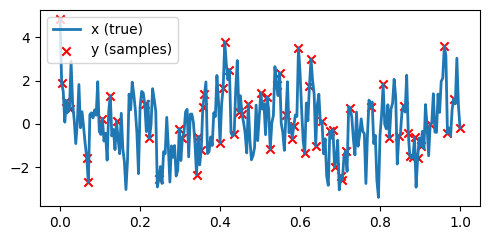

Optimization terminated successfully    (Exit mode 0)
            Current function value: 65.24451001685958
            Iterations: 253
            Function evaluations: 65675
            Gradient evaluations: 253
success: True | MSE: 3.1246119784737084e-07


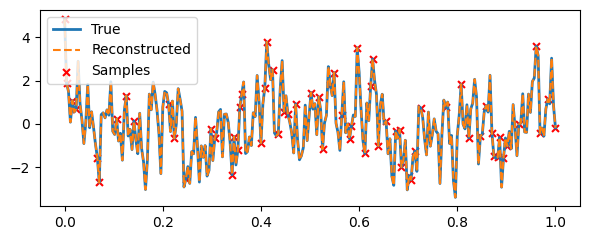

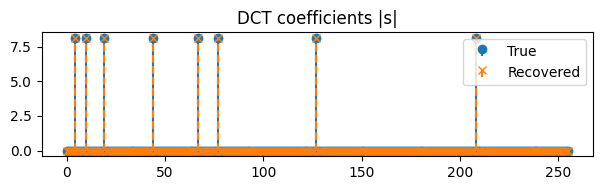

In [ ]:
# ======================================
# Compressed Sensing (1D)
# ======================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import idct
from scipy.optimize import minimize

# Hyperparameters
n_points = 256
n_samples = 64
n_nonzeros = 8
rng = np.random.default_rng(0)

# ======================================
# Generate Sparse Signal in DCT Domain
# ======================================
s_true = np.zeros(n_points)
s_true[rng.choice(n_points, n_nonzeros, replace=False)] = rng.normal(n_nonzeros)
s_flat = idct(s_true, norm='ortho')

# Sampler matrix (select random time samples)
perm = rng.choice(n_points, size=n_samples, replace=False)
C = np.eye(n_points)[perm]
y = C @ s_flat

# Sampling times (for plotting)
t = np.linspace(0, 1, n_points)

# =================================================================
# Plot the true and sampled signal
# =================================================================
plt.figure(figsize=(5, 2.5))
plt.plot(t, s_flat, label='x (true)', lw=2)
plt.scatter(t[perm], y, label='y (samples)', color='red', marker='x')
plt.legend()
plt.tight_layout()
plt.show()

# =================================================================
# Standard Constrained Optimization in NumPy (SLSQP)
# =================================================================
eps = 1e-6
def obj_fn(s):
    # Smooth L1 penalty
    return np.sum(np.sqrt(s**2 + eps))

def cons_fun(s):
    # Enforce that sampled points match y
    return (C @ idct(s, norm='ortho')) - y

con = {'type': 'eq', 'fun': cons_fun}

# Initial guess
s0 = np.zeros(n_points)

# Solve
res = minimize(obj_fn, s0, method='SLSQP', constraints=[con],
               options={'disp': True, 'maxiter': 300, 'ftol': 1e-9})

# Reconstruct
x_hat = idct(res.x, norm='ortho')
print("success:", res.success, "| MSE:", np.mean((x_hat - s_flat)**2))

# =================================================================
# Plot reconstruction and DCT spectra
# =================================================================
plt.figure(figsize=(6, 2.5))
plt.plot(t, s_flat, label='True', lw=2)
plt.plot(t, x_hat, '--', label='Reconstructed', lw=1.5)
plt.scatter(t[perm], y, color='red', marker='x', s=25, label='Samples')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6, 2))
plt.stem(np.abs(s_true), linefmt='C0-', markerfmt='C0o', basefmt=' ')
plt.stem(np.abs(res.x), linefmt='C1--', markerfmt='C1x', basefmt=' ')
plt.legend(['True', 'Recovered'])
plt.title('DCT coefficients |s|')
plt.tight_layout(); plt.show()


##### 2D Cosine

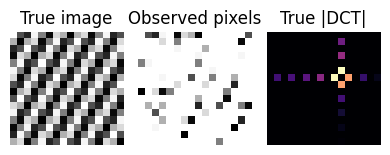

  NIT    FC           OBJFUN            GNORM
    1   258     6.027300E+01     1.192093E-04
    2   520     2.490520E+02     5.683871E+00
    3   777     2.246111E+02     1.599876E+01
    4  1034     2.381265E+02     1.599014E+01
    5  1292     2.663858E+02     1.599850E+01
    6  1550     2.195807E+02     1.599091E+01
    7  1808     2.388202E+02     1.597898E+01
    8  2066     2.114094E+02     1.599734E+01
    9  2324     2.394121E+02     1.599682E+01
   10  2583     2.414553E+02     1.596514E+01
   11  2842     2.651292E+02     1.598330E+01
   12  3101     2.194549E+02     1.598065E+01
   13  3360     2.678115E+02     1.591382E+01
   14  3619     2.350870E+02     1.596865E+01
   15  3878     2.568486E+02     1.594513E+01
   16  4137     2.301848E+02     1.592992E+01
   17  4396     2.727936E+02     1.592317E+01
   18  4655     2.517459E+02     1.593287E+01
   19  4914     2.514016E+02     1.591919E+01
   20  5173     2.191359E+02     1.597773E+01
   21  5432     2.266435E+02     1

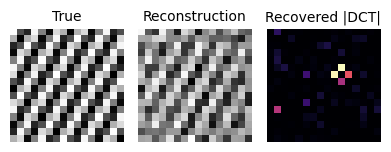

In [30]:
# ==============================================
# Compressed Sensing (2D) — Cosine Ground Truth
# ==============================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dctn, idctn
from scipy.optimize import minimize

# Hyperparameters
H, W = 16, 16                  # image size (keep modest for SLSQP)
m = int(0.2*H*W)                   # number of observed pixels (~16%)
eps = 1e-6                     # smoothing for L1
rng = np.random.default_rng(0)

# ======================================
# True image as a sum of 2D cosines
# ======================================
# Choose a few frequency pairs (kx, ky) and amplitudes
freqs = [(3, 5)]
amps  = [1.0]
i = np.arange(H)[:, None]
j = np.arange(W)[None, :]
x_true = sum(a * np.cos(2*np.pi*(kx*i/H + ky*j/W)) for (kx, ky), a in zip(freqs, amps))

# For visualization: true DCT spectrum (should be sparse-ish)
s_true = dctn(x_true, norm='ortho')

# Random pixel sampling
obs_idx = rng.choice(H*W, size=m, replace=False)
w = np.eye(H*W)[obs_idx]
y = w @ x_true.reshape(-1)
# y = x_true.reshape(-1)[obs_idx]

def observed_array(vals):
    out = np.full((H, W), np.nan, float)
    out.reshape(-1)[obs_idx] = vals
    return out

# =================================================================
# Plot the true image and observed pixels
# =================================================================
plt.figure(figsize=(4,3))
plt.subplot(1,3,1); plt.title('True image'); plt.imshow(x_true, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title('Observed pixels'); plt.imshow(observed_array(y), cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title('True |DCT|'); plt.imshow(np.abs(s_true), cmap='magma'); plt.axis('off')
plt.tight_layout(); plt.show()

# =================================================================
# Standard Constrained Optimization in NumPy (SLSQP)
# Variables live in DCT domain: s (flattened), x = idctn(reshape(s))
# =================================================================
def obj_fn(s_flat):
    return np.sum(np.sqrt(s_flat*s_flat + eps))   # smoothed L1
    # return np.linalg.norm(s_flat, 1)
def cons_fun(s_flat):
    s2d = s_flat.reshape(H, W)
    x_rec = idctn(s2d, norm='ortho').reshape(-1)
    return x_rec[obs_idx] - y

con = {'type': 'eq', 'fun': cons_fun}
s0 = np.zeros(H*W)

res = minimize(
    obj_fn, s0, method='SLSQP', constraints=[con],
    tol=1e-10,
    options={'disp': True, 'iprint': 10}
)

# Reconstruct
s_hat = res.x.reshape(H, W)
x_hat = idctn(s_hat, norm='ortho')
mse = np.mean((x_hat - x_true)**2)
print("success:", res.success, "| MSE:", f"{mse:.3e}")

# =================================================================
# Plots: reconstruction and recovered spectrum
# =================================================================
plt.figure(figsize=(4,3))
plt.subplot(1,3,1); plt.title('True', fontsize=10); plt.imshow(x_true, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title('Reconstruction', fontsize=10); plt.imshow(x_hat, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title('Recovered |DCT|', fontsize=10); plt.imshow(np.abs(s_hat), cmap='magma'); plt.axis('off')
plt.tight_layout(); plt.show()


##### 2D Image

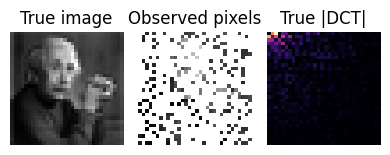

Iteration limit reached    (Exit mode 9)
            Current function value: 374.0228533859946
            Iterations: 100
            Function evaluations: 102760
            Gradient evaluations: 100
success: False | MSE: 1.302e+00


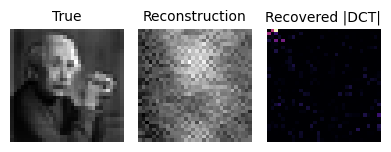

In [81]:
# ==============================================
# Compressed Sensing (2D) — Image Ground Truth
# ==============================================

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dctn, idctn
from scipy.optimize import minimize

# Hyperparameters
H, W = 32, 32                    # image size (keep modest for SLSQP)
m = int(0.2*H*W)                 # number of observed pixels (~16%)
eps = 1e-6                       # smoothing for L1
rng = np.random.default_rng(0)

# ======================================
# True image as a sum of 2D cosines
# ======================================
def load_image(filepath, size=(32, 32), show=False):
    img = Image.open(filepath).convert("L")  # converts to grayscale
    img_resized = img.resize(size, Image.Resampling.LANCZOS)
    x_down = np.asarray(img_resized, dtype=np.float32)
    if show:
        plt.imshow(img_resized, cmap='gray')
        plt.show()
    return x_down

filepath = "../../data/einstein/einstein.jpg"
x_true = load_image(filepath, (H, W)).astype(np.float32)
x_true = (x_true - x_true.mean()) / (x_true.std() + 1e-8)


# For visualization: true DCT spectrum (should be sparse-ish)
s_true = dctn(x_true, norm='ortho')

# Random pixel sampling
obs_idx = rng.choice(H*W, size=m, replace=False)
w = np.eye(H*W)[obs_idx]
y = w @ x_true.reshape(-1)

def observed_array(vals):
    out = np.full((H, W), np.nan, float)
    out.reshape(-1)[obs_idx] = vals
    return out

# =================================================================
# Plot the true image and observed pixels
# =================================================================
plt.figure(figsize=(4,3))
plt.subplot(1,3,1); plt.title('True image'); plt.imshow(x_true, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title('Observed pixels'); plt.imshow(observed_array(y), cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title('True |DCT|'); plt.imshow(np.abs(s_true), cmap='magma'); plt.axis('off')
plt.tight_layout(); plt.show()

# =================================================================
# Standard Constrained Optimization in NumPy (SLSQP)
# Variables live in DCT domain: s (flattened), x = idctn(reshape(s))
# =================================================================
def obj_fn(s_flat):
    return np.sum(np.sqrt(s_flat*s_flat + eps))   # smoothed L1
    # return np.linalg.norm(s_flat, 1)
def cons_fun(s_flat):
    s2d = s_flat.reshape(H, W)
    x_rec = idctn(s2d, norm='ortho').reshape(-1)
    return x_rec[obs_idx] - y

con = {'type': 'eq', 'fun': cons_fun}
s0 = np.zeros(H*W)

res = minimize(
    obj_fn, s0, method='SLSQP', constraints=[con],
    tol=1e-10,
    options={'disp': True, 'iprint': 2}
)

# Reconstruct
s_hat = res.x.reshape(H, W)
x_hat = idctn(s_hat, norm='ortho')
mse = np.mean((x_hat - x_true)**2)
print("success:", res.success, "| MSE:", f"{mse:.3e}")

# =================================================================
# Plots: reconstruction and recovered spectrum
# =================================================================
plt.figure(figsize=(4,3))
plt.subplot(1,3,1); plt.title('True', fontsize=10); plt.imshow(x_true, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title('Reconstruction', fontsize=10); plt.imshow(x_hat, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title('Recovered |DCT|', fontsize=10); plt.imshow(np.abs(s_hat), cmap='magma'); plt.axis('off')
plt.tight_layout(); plt.show()


#### Tensorized compressed sensing

##### 2D Cosine

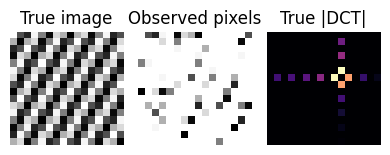

Iteration limit reached    (Exit mode 9)
            Current function value: 7.096117443478795
            Iterations: 100
            Function evaluations: 25710
            Gradient evaluations: 100
success: False | MSE: 4.042e-01
Optimization finished in 12.18 seconds.


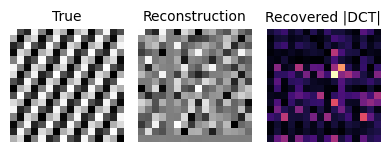

In [68]:
# =======================================================
# Tensorized Compressed Sensing (2D) — Cosine Ground Truth
# =======================================================

import time
import quimb.tensor as qtn
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dctn, idctn
from scipy.optimize import minimize

# Hyperparameters
H, W = 16, 16                      # image size (keep modest for SLSQP)
# tensor_shape = (4, 4, 4, 4)
physical_dim = 4
n_cores = 4
rank = 4
m = int(0.2*H*W)                   # number of observed pixels (~16%)
eps = 1e-6                         # smoothing for L1
rng = np.random.default_rng(0)

# ======================================
# True image as a sum of 2D cosines
# ======================================
# Choose a few frequency pairs (kx, ky) and amplitudes
freqs = [(3, 5)]
amps  = [1.0]
i = np.arange(H)[:, None]
j = np.arange(W)[None, :]
x_true = sum(a * np.cos(2*np.pi*(kx*i/H + ky*j/W)) for (kx, ky), a in zip(freqs, amps))

# For visualization: true DCT spectrum (should be sparse-ish)
s_true = dctn(x_true, norm='ortho')

# Random pixel sampling
obs_idx = rng.choice(H*W, size=m, replace=False)
w = np.eye(H*W)[obs_idx]
y = w @ x_true.reshape(-1)

def observed_array(vals):
    out = np.full((H, W), np.nan, float)
    out.reshape(-1)[obs_idx] = vals
    return out

# =================================================================
# Plot the true image and observed pixels
# =================================================================
plt.figure(figsize=(4,3))
plt.subplot(1,3,1); plt.title('True image'); plt.imshow(x_true, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title('Observed pixels'); plt.imshow(observed_array(y), cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title('True |DCT|'); plt.imshow(np.abs(s_true), cmap='magma'); plt.axis('off')
plt.tight_layout(); plt.show()

# =================================================================
# Standard Constrained Optimization in NumPy (SLSQP)
# Variables live in DCT domain: s (flattened), x = idctn(reshape(s))
# =================================================================
# def obj_fn(s_flat):
#     return np.sum(np.sqrt(s_flat*s_flat + eps))   # smoothed L1
#     # return np.linalg.norm(s_flat, 1)
    
# def cons_fun(s_flat):
#     s2d = s_flat.reshape(H, W)
#     x_rec = idctn(s2d, norm='ortho').reshape(-1)
#     return x_rec[obs_idx] - y

def vec2mps(x, L, R, D) -> qtn.MatrixProductState:
     x = x.reshape(L, R, R, D)
     return qtn.MatrixProductState([x[0][0:1, ...]] + [x[i] for i in range(1, L-1)] + [x[L-1][..., 0:1, :]])

def vec2mpo(x, L, R, D) -> qtn.MatrixProductOperator:
     x = x.reshape(L, R, R, D, D)
     return qtn.MatrixProductOperator([x[0][0:1, ...]] + [x[i] for i in range(1, L-1)] + [x[L-1][..., 0:1, :, :]])


def obj_fn(s_flat, L, R, D, verbose=False):
    # x represents a D^H tensor via a TT-vector. Shape: (H*R^2*D)
    s_flat = s_flat.reshape(L, R, R, D)
    s_mps = vec2mps(s_flat, L, R, D)
    return s_mps.norm()  # should make l1 norm


def cons_fun(s_flat, L, R, D):
    # return (w_mpo.apply(vec2mps(s_flat, L, R, D)) - y_mps).norm()
    s_flat = s_flat.reshape(L, R, R, D)
    s_mps = vec2mps(s_flat, L, R, D)
    s_mps_dense = s_mps.to_dense()
    s2d = s_mps_dense.reshape(H, W)
    x_rec = idctn(s2d, norm='ortho').reshape(-1)
    return w @ x_rec - y


L, R, D = n_cores, rank, physical_dim
con = {'type': 'eq', 'fun': lambda s_flat: cons_fun(s_flat, L, R, D)}
# s0 = np.zeros(H*W)
s0 = np.random.rand(L*R*R*D)

start = time.time()
res = minimize(
    lambda s_flat: obj_fn(s_flat, L, R, D), 
    s0, method='SLSQP', 
    constraints=[con],
    tol=1e-10,
    options={'disp': True, 'iprint': 1}
)

# Reconstruct
def get_dense_tensor(s_flat, L, R, D):
    s_flat = res.x.reshape(L, R, R, D)
    s_mps = vec2mps(s_flat, L, R, D)
    s_mps_dense = s_mps.to_dense()
    return s_mps_dense
s_dense = get_dense_tensor(res.x, L, R, D)
s_hat = s_dense.reshape(H, W)
x_hat = idctn(s_hat, norm='ortho')
mse = np.mean((x_hat - x_true)**2)
print("success:", res.success, "| MSE:", f"{mse:.3e}")
print(f"Optimization finished in {time.time() - start:.2f} seconds.")

# =================================================================
# Plots: reconstruction and recovered spectrum
# =================================================================
plt.figure(figsize=(4,3))
plt.subplot(1,3,1); plt.title('True', fontsize=10); plt.imshow(x_true, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title('Reconstruction', fontsize=10); plt.imshow(x_hat, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title('Recovered |DCT|', fontsize=10); plt.imshow(np.abs(s_hat), cmap='magma'); plt.axis('off')
plt.tight_layout(); plt.show()


##### Image

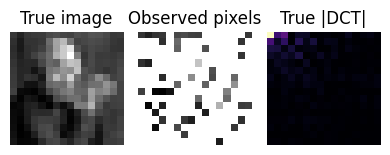

Iteration limit reached    (Exit mode 9)
            Current function value: 611.5495416264339
            Iterations: 100
            Function evaluations: 25805
            Gradient evaluations: 100
success: False | MSE: 3.166e+03
Optimization finished in 12.38 seconds.


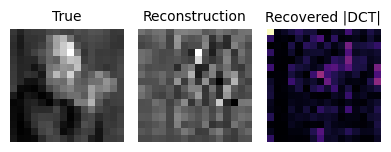

In [ ]:
# =======================================================
# Tensorized Compressed Sensing (2D) — Cosine Ground Truth
# =======================================================

import time
from PIL import Image
import quimb.tensor as qtn
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dctn, idctn
from scipy.optimize import minimize

# Hyperparameters
H, W = 16, 16                      # image size (keep modest for SLSQP)
physical_dim = 4
n_cores = 4
rank = 4
m = int(0.2*H*W)                   # number of observed pixels (~16%)
eps = 1e-6                         # smoothing for L1
rng = np.random.default_rng(0)

# ======================================
# True image as a sum of 2D cosines
# ======================================
# Choose a few frequency pairs (kx, ky) and amplitudes
# freqs = [(3, 5)]
# amps  = [1.0]
# i = np.arange(H)[:, None]
# j = np.arange(W)[None, :]
# x_true = sum(a * np.cos(2*np.pi*(kx*i/H + ky*j/W)) for (kx, ky), a in zip(freqs, amps))

def load_image(filepath, size=(32, 32), show=False):
    img = Image.open(filepath).convert("L")  # converts to grayscale
    img_resized = img.resize(size, Image.Resampling.LANCZOS)
    x_down = np.asarray(img_resized, dtype=np.float32)
    if show:
        plt.imshow(img_resized, cmap='gray')
        plt.show()
    return x_down

filepath = "../../data/einstein/einstein.jpg"
x_true = load_image(filepath, (H, W)).astype(np.float32)
x_true = (x_true - x_true.mean()) / (x_true.std() + 1e-8)

# For visualization: true DCT spectrum (should be sparse-ish)
s_true = dctn(x_true, norm='ortho')

# Random pixel sampling
obs_idx = rng.choice(H*W, size=m, replace=False)
w = np.eye(H*W)[obs_idx]
y = w @ x_true.reshape(-1)

def observed_array(vals):
    out = np.full((H, W), np.nan, float)
    out.reshape(-1)[obs_idx] = vals
    return out

# =================================================================
# Plot the true image and observed pixels
# =================================================================
plt.figure(figsize=(4,3))
plt.subplot(1,3,1); plt.title('True image'); plt.imshow(x_true, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title('Observed pixels'); plt.imshow(observed_array(y), cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title('True |DCT|'); plt.imshow(np.abs(s_true), cmap='magma'); plt.axis('off')
plt.tight_layout(); plt.show()

# =================================================================
# Standard Constrained Optimization in NumPy (SLSQP)
# Variables live in DCT domain: s (flattened), x = idctn(reshape(s))
# =================================================================
# def obj_fn(s_flat):
#     return np.sum(np.sqrt(s_flat*s_flat + eps))   # smoothed L1
#     # return np.linalg.norm(s_flat, 1)
    
# def cons_fun(s_flat):
#     s2d = s_flat.reshape(H, W)
#     x_rec = idctn(s2d, norm='ortho').reshape(-1)
#     return x_rec[obs_idx] - y

def vec2mps(x, L, R, D) -> qtn.MatrixProductState:
     x = x.reshape(L, R, R, D)
     return qtn.MatrixProductState([x[0][0:1, ...]] + [x[i] for i in range(1, L-1)] + [x[L-1][..., 0:1, :]])

def vec2mpo(x, L, R, D) -> qtn.MatrixProductOperator:
     x = x.reshape(L, R, R, D, D)
     return qtn.MatrixProductOperator([x[0][0:1, ...]] + [x[i] for i in range(1, L-1)] + [x[L-1][..., 0:1, :, :]])


def obj_fn(s_flat, L, R, D, verbose=False):
    # x represents a D^H tensor via a TT-vector. Shape: (H*R^2*D)
    s_flat = s_flat.reshape(L, R, R, D)
    s_mps = vec2mps(s_flat, L, R, D)
    return s_mps.norm()  # should make l1 norm


def cons_fun(s_flat, L, R, D):
    # return (w_mpo.apply(vec2mps(s_flat, L, R, D)) - y_mps).norm()
    s_flat = s_flat.reshape(L, R, R, D)
    s_mps = vec2mps(s_flat, L, R, D)
    s_mps_dense = s_mps.to_dense()
    s2d = s_mps_dense.reshape(H, W)
    x_rec = idctn(s2d, norm='ortho').reshape(-1)
    return w @ x_rec - y


L, R, D = n_cores, rank, physical_dim
con = {'type': 'eq', 'fun': lambda s_flat: cons_fun(s_flat, L, R, D)}
# s0 = np.zeros(H*W)
s0 = np.random.rand(L*R*R*D)

start = time.time()
res = minimize(
    lambda s_flat: obj_fn(s_flat, L, R, D), 
    s0, method='SLSQP', 
    constraints=[con],
    tol=1e-10,
    options={'disp': True, 'iprint': 1}
)

# Reconstruct
def get_dense_tensor(s_flat, L, R, D):
    s_flat = res.x.reshape(L, R, R, D)
    s_mps = vec2mps(s_flat, L, R, D)
    s_mps_dense = s_mps.to_dense()
    return s_mps_dense
s_dense = get_dense_tensor(res.x, L, R, D)
s_hat = s_dense.reshape(H, W)
x_hat = idctn(s_hat, norm='ortho')
mse = np.mean((x_hat - x_true)**2)
print("success:", res.success, "| MSE:", f"{mse:.3e}")
print(f"Optimization finished in {time.time() - start:.2f} seconds.")

# =================================================================
# Plots: reconstruction and recovered spectrum
# =================================================================
plt.figure(figsize=(4,3))
plt.subplot(1,3,1); plt.title('True', fontsize=10); plt.imshow(x_true, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title('Reconstruction', fontsize=10); plt.imshow(x_hat, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title('Recovered |DCT|', fontsize=10); plt.imshow(np.abs(s_hat), cmap='magma'); plt.axis('off')
plt.tight_layout(); plt.show()


##### FISTA

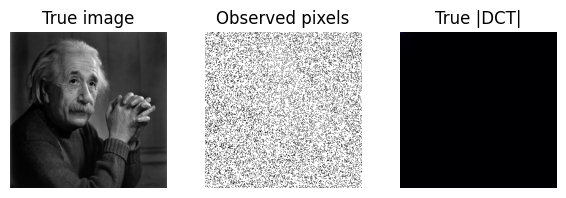

FISTA iters=2000, MSE=1.291e+02, PSNR=26.99 dB


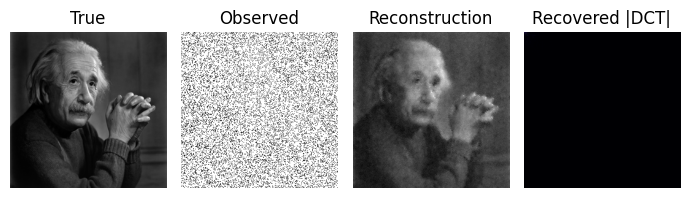

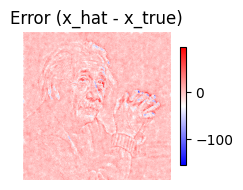

In [ ]:
# ==========================================
# Compressed Sensing (2D, FISTA, DCT-sparse)
# ==========================================

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dctn, idctn

# Hyperparameters
H, W = 256, 256           # image size (increase as you wish)
sample_frac = 0.20        # fraction of observed pixels
lam = 1e-2                # L1 weight (tune for your data)
max_iter = 2000
tol = 1e-6
rng = np.random.default_rng(0)

# ======================================
# True image: sum of a few 2D cosines
# ======================================
# freqs = [(8, 5), (15, 12), (31, 21), (42, 7)]
# amps  = [1.0, 0.8, 0.6, 0.5]
# i = np.arange(H)[:, None]
# j = np.arange(W)[None, :]
# x_true = sum(a * np.cos(2*np.pi*(kx*i/H + ky*j/W)) for (kx, ky), a in zip(freqs, amps))

def load_image(filepath, size=(32, 32), show=False):
    img = Image.open(filepath).convert("L")  # converts to grayscale
    img_resized = img.resize(size, Image.Resampling.LANCZOS)
    x_down = np.asarray(img_resized, dtype=np.float32)
    if show:
        plt.imshow(img_resized, cmap='gray')
        plt.show()
    return x_down

filepath = "../../data/einstein/einstein.jpg"
x_true = load_image(filepath, (H, W))

# Random pixel sampling
m = int(sample_frac * H * W)
obs_flat = rng.choice(H*W, size=m, replace=False)
mask = np.zeros(H*W, dtype=bool); mask[obs_flat] = True
mask = mask.reshape(H, W)
y = x_true[mask]

def show_observed(vals):
    out = np.full((H, W), np.nan, float)
    out[mask] = vals
    return out

# =================================================================
# Plot: true image and observed pixels
# =================================================================
plt.figure(figsize=(6,2))
plt.subplot(1,3,1); plt.title('True image'); plt.imshow(x_true, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title('Observed pixels'); plt.imshow(show_observed(y), cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title('True |DCT|'); plt.imshow(np.abs(dctn(x_true, norm="ortho")), cmap='magma'); plt.axis('off')
plt.tight_layout(); plt.show()

# =================================================================
# FISTA:  min_S  0.5||A(S)-y||^2 + lam||S||_1
# where A(S) = idctn(S)[mask], A^T(r) = dctn(embed(r,mask))
# =================================================================
def A(S):
    return idctn(S, norm='ortho')[mask]

def AT(r):
    V = np.zeros((H, W), dtype=float)
    V[mask] = r
    return dctn(V, norm='ortho')

def soft(z, tau):
    return np.sign(z) * np.maximum(np.abs(z) - tau, 0.0)

# Init
S = np.zeros((H, W), dtype=float)  # DCT coefficients
Z = S.copy()
t = 1.0
tau = 1.0  # Lipschitz <= 1 for this A with orthonormal DCT

# FISTA loop
for it in range(1, max_iter+1):
    r = A(Z) - y
    grad = AT(r)
    S_next = soft(Z - tau*grad, lam*tau)
    t_next = 0.5*(1 + np.sqrt(1 + 4*t*t))
    Z = S_next + ((t - 1)/t_next) * (S_next - S)

    # stop?
    if np.linalg.norm(S_next - S) / (np.linalg.norm(S) + 1e-12) < tol:
        S = S_next
        break
    S, t = S_next, t_next

x_hat = idctn(S, norm='ortho')
mse = np.mean((x_true - x_hat)**2)
psnr = 10*np.log10(np.max(x_true**2) / (mse + 1e-12))
print(f"FISTA iters={it}, MSE={mse:.3e}, PSNR={psnr:.2f} dB")

# =================================================================
# Plots: reconstruction, error, recovered |DCT|
# =================================================================
plt.figure(figsize=(7,2))
plt.subplot(1,4,1); plt.title('True'); plt.imshow(x_true, cmap='gray'); plt.axis('off')
plt.subplot(1,4,2); plt.title('Observed'); plt.imshow(show_observed(y), cmap='gray'); plt.axis('off')
plt.subplot(1,4,3); plt.title('Reconstruction'); plt.imshow(x_hat, cmap='gray'); plt.axis('off')
plt.subplot(1,4,4); plt.title('Recovered |DCT|'); plt.imshow(np.abs(S), cmap='magma'); plt.axis('off')
plt.tight_layout(); plt.show()

plt.figure(figsize=(2.5,2))
plt.title('Error (x_hat - x_true)')
plt.imshow(x_hat - x_true, cmap='bwr'); plt.axis('off'); plt.colorbar(shrink=0.8)
plt.tight_layout(); plt.show()


### Tensor completion

In [1]:
# ===================================
# Tensor completion (Basic Example)
# ===================================

import tntorch as tn
import torch

# Model
t = tn.rand(32, 32, 32, ranks_tt=6, requires_grad=True)

# Data
X = [[0, 0, 0], [0, 0, 1], [0, 0, 2]]
y = torch.randn(3)

def loss(t):
    return tn.relative_error(y, t[X])
tn.optimize(t, loss)


iter: 0       | loss:   4.453255 | total time:    0.0391
iter: 500     | loss:   0.856309 | total time:    0.2042
iter: 612     | loss:   0.837312 | total time:    0.2405 <- converged (tol=0.0001)


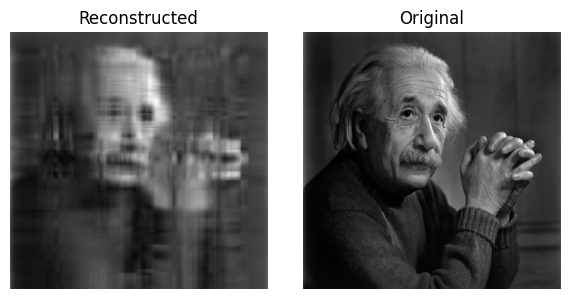

In [ ]:
# ======================================
# Tensor decomposition (Basic Example)
# ======================================

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_image(filepath, size=(600, 600), show=False):
    img = Image.open(filepath).convert("L")  # converts to grayscale
    img_resized = img.resize(size, Image.Resampling.LANCZOS)
    x_down = np.asarray(img_resized, dtype=np.float32)
    if show:
        plt.imshow(img_resized, cmap='gray')
        plt.show()
    return x_down

filepath = "../../data/einstein/einstein.jpg"
height, width = 512, 512
size = (height, width)
n_samples = int(0.1*height*width)
tensor_shape = (8, 8, 8, 8, 8, 8, 8)
rank = 8
image_shape = (height, width)


# Data
s_flat = torch.tensor(load_image(filepath, size))
s_flat = (s_flat - s_flat.mean()) / s_flat.std()
t = tn.Tensor(s_flat, ranks_tt=rank)  # You can also pass a list of ranks

# Plot side-by-side and small
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
x_recons = t.numpy().reshape(*image_shape)
axs[0].imshow(x_recons, vmin=x_recons.min(), vmax=x_recons.max(), cmap='gray')
axs[0].set_title("Reconstructed")
axs[0].axis('off')
axs[1].imshow(s_flat, vmin=s_flat.min(), vmax=s_flat.max(), cmap='gray')
axs[1].set_title("Original")
axs[1].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Hyperparameters
filepath = "../../data/einstein/einstein.jpg"
height, width = 64, 64
size = (height, width)
n_samples = int(1.0*height*width)
tensor_shape = (8, 8, 8, 8)
rank = 8
image_shape = (height, width)

# Data
s_flat = torch.tensor(load_image(filepath, size, show=False))
s_flat = (s_flat - s_flat.mean()) / s_flat.std()
ids = torch.randperm(height*width)[:n_samples]
ids_tens = torch.unravel_index(ids, tensor_shape)
y = s_flat.reshape(-1).gather(0, ids)  # (n_samples,)
print(f"y: {y.shape} | ids_tens: {ids_tens[0].shape}")

# # =================================================================
# # Sanity check plot samples
# # =================================================================
# obs = np.full((height, width), np.nan, dtype=np.float32)
# r, c = [ids_i.cpu().numpy() for ids_i in torch.unravel_index(ids, (height, width))]
# v = x.reshape(-1)[ids].detach().cpu().numpy()
# v = (v - v.min()) / (v.max() - v.min() + 1e-8)

# obs[r, c] = v
# plt.figure()
# plt.imshow(obs, cmap='gray', vmin=0, vmax=1, origin='upper')  # no axis flip needed
# plt.title("Observed pixels (imshow)")
# plt.axis('off')
# plt.show()
# # =================================================================

# Model
# MPS model
t = tn.rand(*tensor_shape, ranks_tt=rank, requires_grad=True)

# Loss
def loss(t):
    return tn.dist(y, t[ids_tens])

# Optimize
tn.optimize(t, loss)

y: torch.Size([4096]) | ids_tens: torch.Size([4096])
iter: 0       | loss: 1822.342163 | total time:    0.0044
iter: 500     | loss: 105.983009 | total time:    2.0665
iter: 1000    | loss:  62.521255 | total time:    4.3140
iter: 1500    | loss:  55.767944 | total time:    6.4243
iter: 2000    | loss:  50.617241 | total time:    8.5855
iter: 2500    | loss:  44.461815 | total time:   10.6909
iter: 3000    | loss:  39.202785 | total time:   12.7824
iter: 3500    | loss:  34.737370 | total time:   14.8460
iter: 4000    | loss:  30.769203 | total time:   16.9092
iter: 4500    | loss:  27.204878 | total time:   18.9713
iter: 5000    | loss:  23.534599 | total time:   20.9183
iter: 5500    | loss:  20.446127 | total time:   22.8445
iter: 5897    | loss:  19.223276 | total time:   24.4322 <- converged (tol=0.0001)


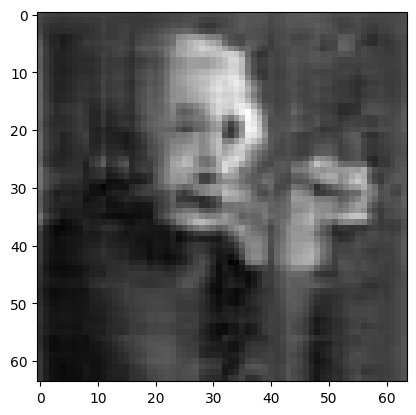

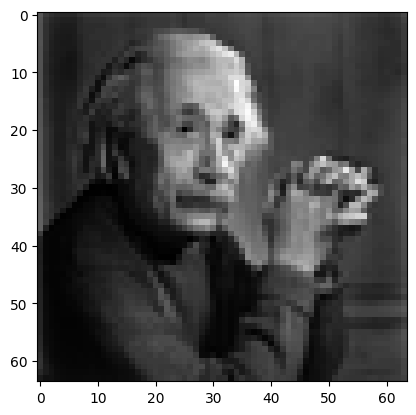

x.min(): -1.42 | x.max(): 4.39 | t.min(): -1.67 | t.max(): 4.09


In [ ]:
plt.imshow(t.numpy().reshape(*image_shape), vmin=t.numpy().min(), vmax=t.numpy().max(), cmap='gray')
plt.show()
plt.imshow(s_flat.numpy(), vmin=s_flat.numpy().min(), vmax=s_flat.numpy().max(), cmap='gray')
plt.show()
print(f"x.min(): {s_flat.numpy().min():.2f} | x.max(): {s_flat.numpy().max():.2f} | t.min(): {t.numpy().min():.2f} | t.max(): {t.numpy().max():.2f}")

In [97]:
import tntorch as tn

tensor_shape = (2,) * 28
t_mps = tn.rand(tensor_shape, ranks_tt=3)
t_mps_exp = tn.exp(t_mps)
# t_mps_exp[0, 0, 0, 0, 0, 0, 0], t_mps[0, 0, 0, 0, 0, 0, 0]


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


ValueError: Invalid return value for function <function exp.<locals>.<lambda> at 0x16db87400>: f(11483.4) = inf